In [40]:
import asyncio
import json
import os
import re
import pandas as pd
import plotly.express as px
import pyshark

In [61]:
def parse_sctp_cwnd_line(line):
    pattern = re.compile(r'sctp\sTRACE\:\s(\d{2}:\d{2}:\d{2}.\d+).*cwnd=(\d+)\sssthresh=(\d+).*')
    match = pattern.match(line)
    if match:
        return {
            'timestamp': match.group(1),
            'cwnd': int(match.group(2)),
            'ssthresh': int(match.group(3)),
        }
    raise ValueError('SCTP log line does not match expected format: ' + line)

In [42]:
def parse_media_cc_line(line):
    pattern = re.compile(r'offerer\sTRACE\:\s(\d{2}:\d{2}:\d{2}.\d+).*target-bitrate=(\d+).*')
    match = pattern.match(line)
    if match:
        return {
            'timestamp': match.group(1),
            'target_rate': int(match.group(2)),
        }
    raise ValueError('CC log line does not match expected format: ' + line)

In [57]:
def read_pion_log(file):
    sctp_cwnd = []
    media_cc = []
    with open(file) as f:
        for line in f:
            if 'updated cwnd=' in line:
                sctp_cwnd.append(parse_sctp_cwnd_line(line))
            if 'offerer TRACE' in line:
                media_cc.append(parse_media_cc_line(line))
    sctp_cwnd_df = pd.DataFrame(sctp_cwnd)
    if 'timestamp' in sctp_cwnd_df.columns:
        sctp_cwnd_df.index = pd.to_datetime(sctp_cwnd_df['timestamp'], format='%H:%M:%S.%f')
    media_cc_df = pd.DataFrame(media_cc)
    if 'timestamp' in media_cc_df.columns:
        media_cc_df.index = pd.to_datetime(media_cc_df['timestamp'], format='%H:%M:%S.%f')
    return sctp_cwnd_df, media_cc_df

In [80]:
async def read_pcap(file, dst_ip=None):
    rtp_data = []
    sctp_data = []
    pcap = pyshark.FileCapture(file, include_raw=True, use_ek=True)
    def append_pkt(packet):
        if 'IP' not in packet or (dst_ip is not None and packet['ip'].dst.value != dst_ip):
            return
        if 'RTP' in packet:
            rtp_data.append({
                'time': packet['udp'].time.relative,
                'length': packet['udp'].length.value,
            })
        if 'DTLS' in packet:
            sctp_data.append({
                'time': packet['udp'].time.relative,
                'length': packet['udp'].length.value,
            })
    await pcap.packets_from_tshark(append_pkt)
    rtp_df = pd.DataFrame(rtp_data)
    if rtp_df.size > 0:
        rtp_df.index = pd.to_datetime(rtp_df['time'], unit='s')
    sctp_df = pd.DataFrame(sctp_data)
    if sctp_df.size > 0:
        sctp_df.index = pd.to_datetime(sctp_df['time'], unit='s')
    return sctp_df, rtp_df

In [81]:
def plot_line(df, y, title=''):
    fig = px.line(x=df.index, y=y, title=title)
    fig.show()

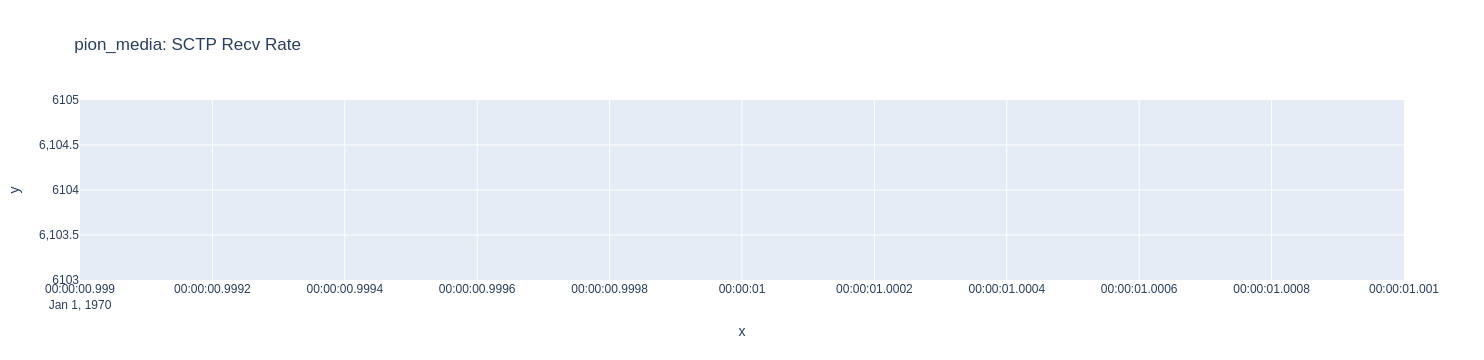

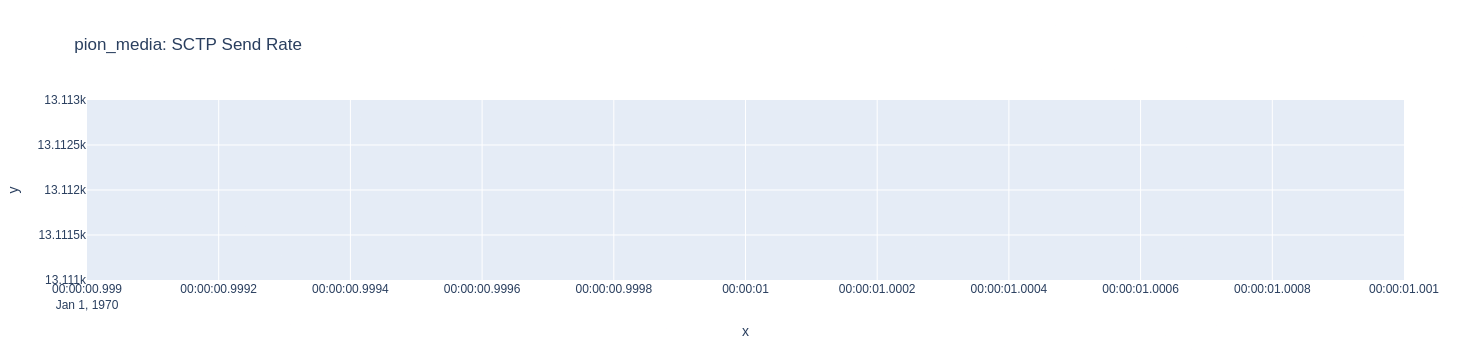

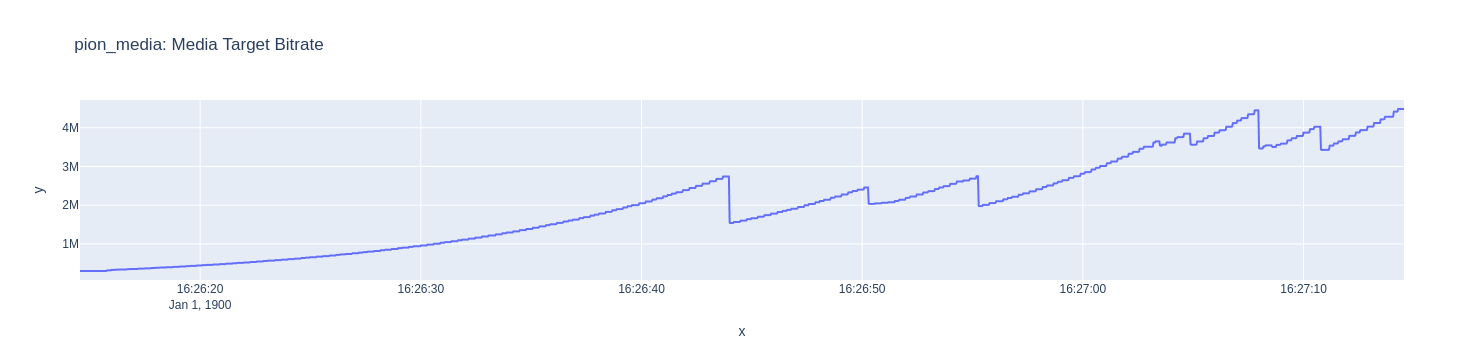

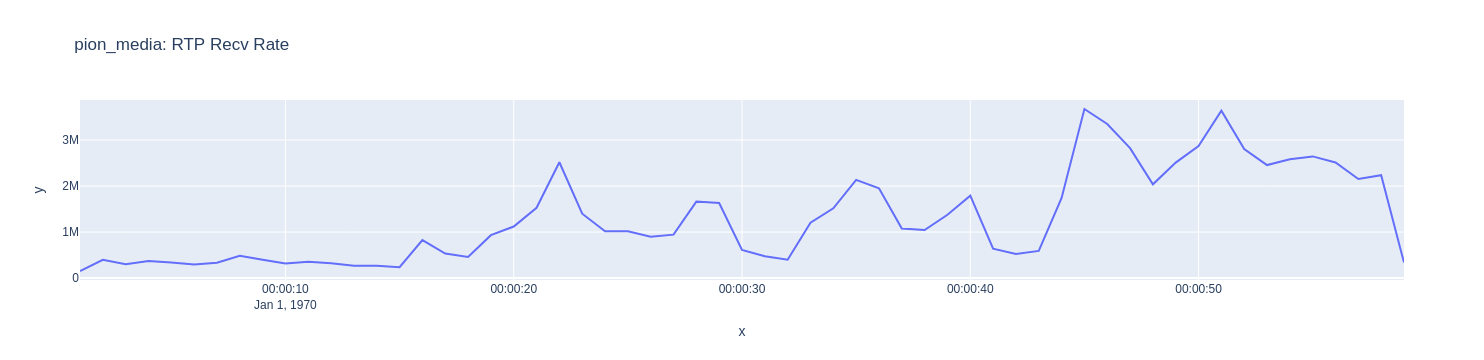

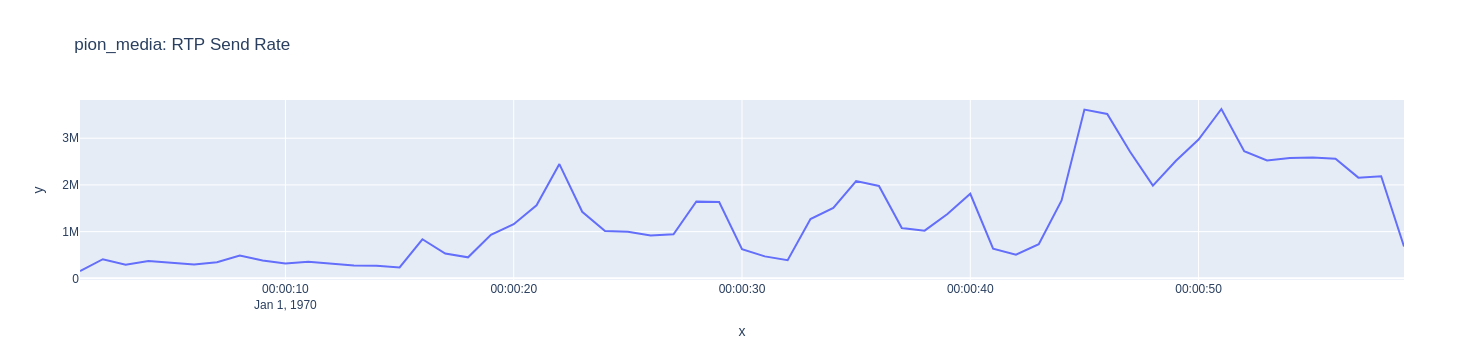

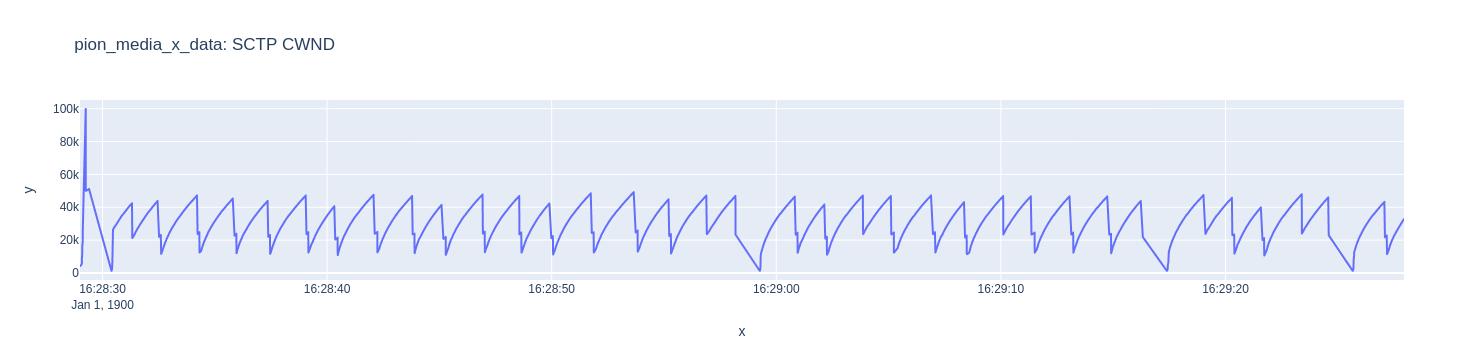

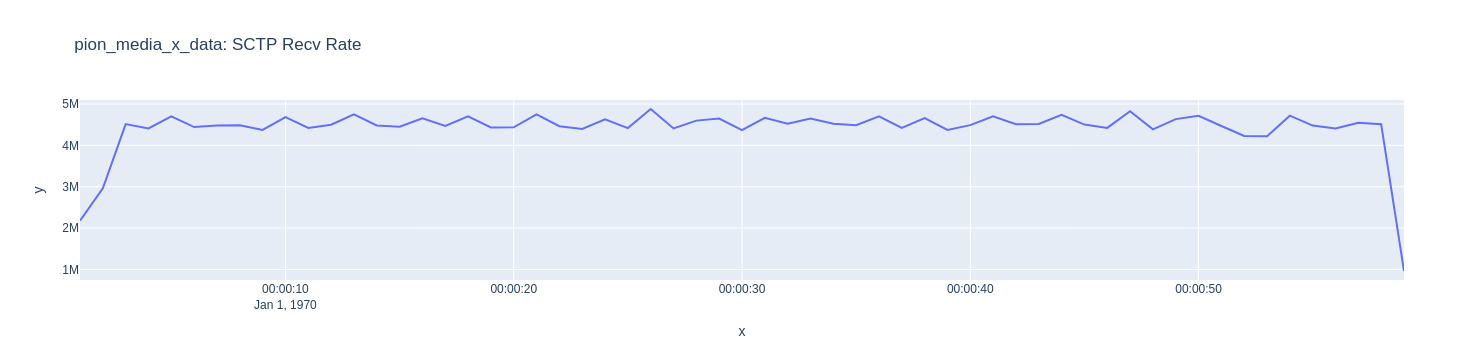

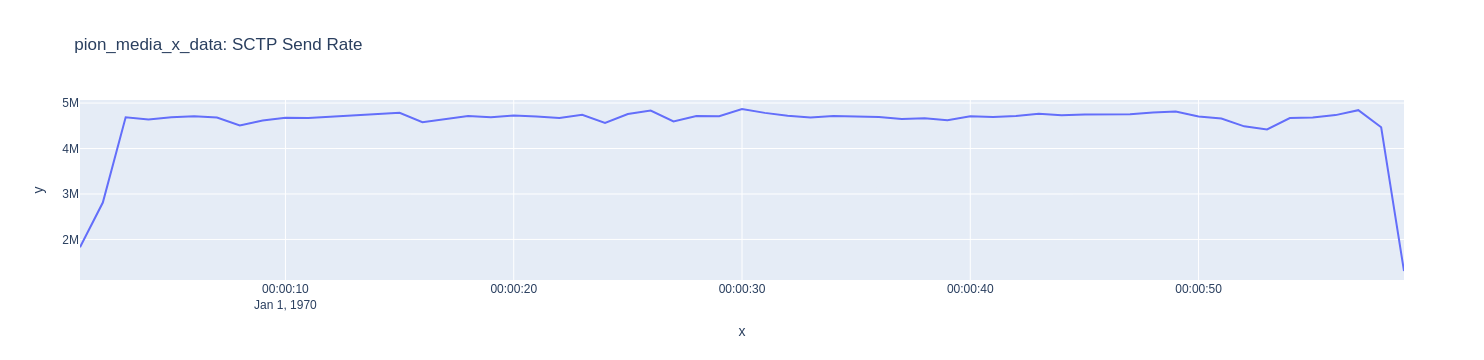

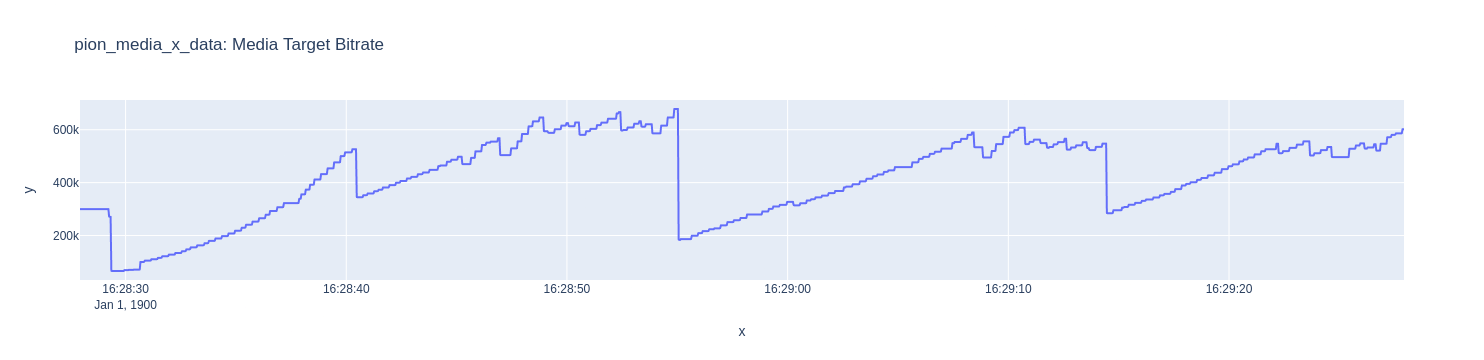

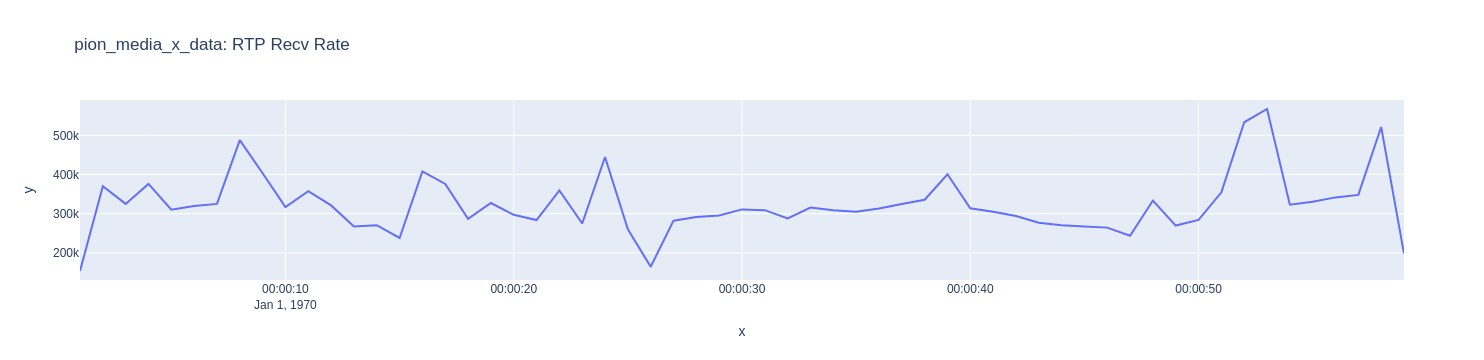

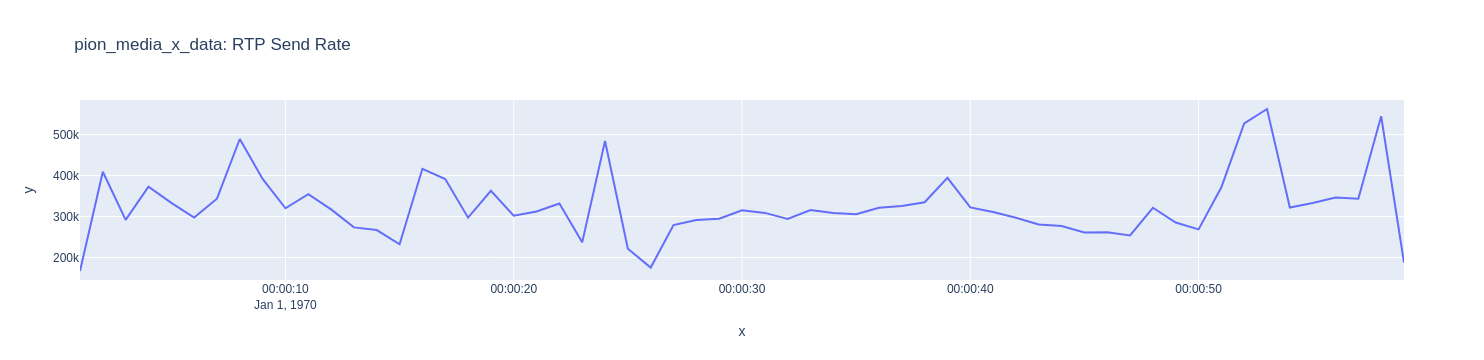

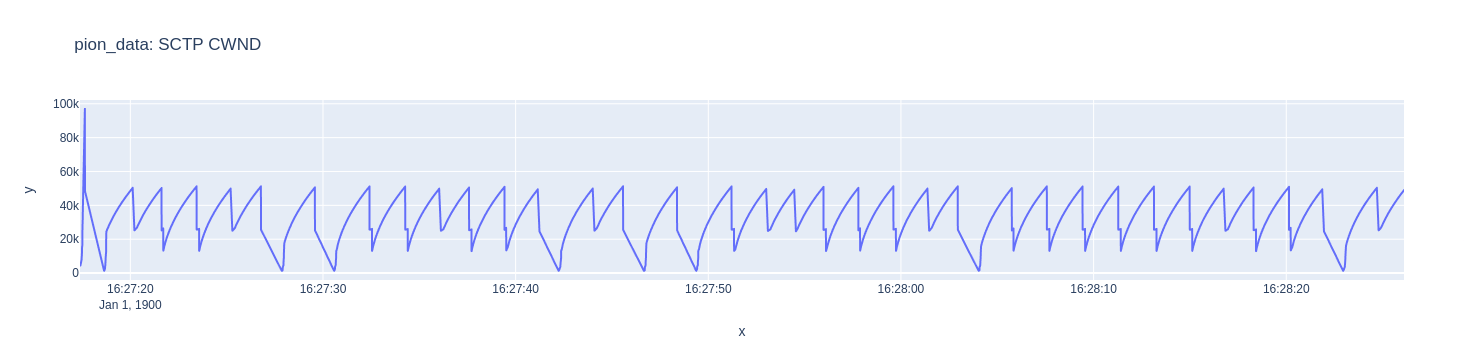

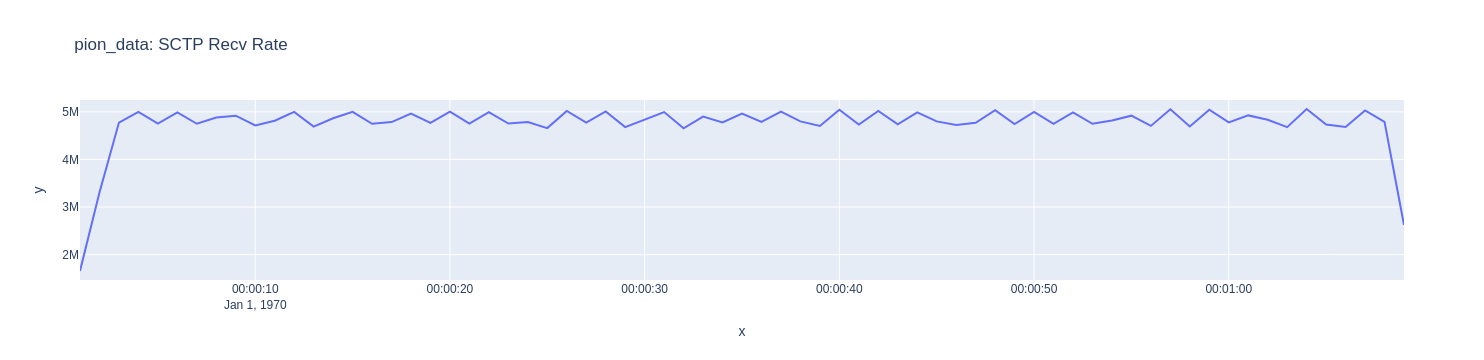

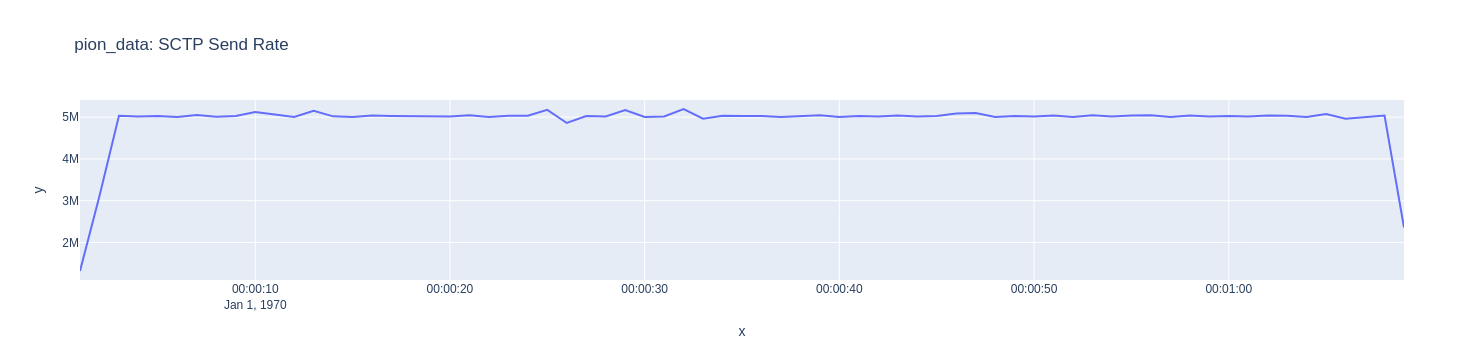

In [83]:
experiments = [
    '../out/pion_media/',
    '../out/pion_media_x_data/',
    '../out/pion_data/',
]

for e in experiments:
    name = os.path.basename(os.path.normpath(e))
    sctp_cwnd_df, media_target_rate_df = read_pion_log(f'{e}/offer.log')
    sctp_send_rate_df, rtp_send_rate_df = await read_pcap(f'{e}/offerer.pcap', dst_ip='10.1.0.10')
    sctp_recv_rate_df, rtp_recv_rate_df = await read_pcap(f'{e}/answerer.pcap')

    if sctp_cwnd_df.size > 0:
        plot_line(sctp_cwnd_df, sctp_cwnd_df['cwnd'], f'{name}: SCTP CWND')
    if sctp_send_rate_df.size > 0:
        sctp_send_rate_df['bits'] = sctp_send_rate_df['length'].apply(lambda x: x * 8)
        sctp_send_rate_df = sctp_send_rate_df.resample('1s').sum()
        plot_line(sctp_send_rate_df, sctp_send_rate_df['bits'], f'{name}: SCTP Recv Rate')
    if sctp_recv_rate_df.size > 0:
        sctp_recv_rate_df['bits'] = sctp_recv_rate_df['length'].apply(lambda x: x * 8)
        sctp_recv_rate_df = sctp_recv_rate_df.resample('1s').sum()
        plot_line(sctp_recv_rate_df, sctp_recv_rate_df['bits'], f'{name}: SCTP Send Rate')
    if media_target_rate_df.size > 0:
        plot_line(media_target_rate_df, media_target_rate_df['target_rate'], f'{name}: Media Target Bitrate')
    if rtp_recv_rate_df.size > 0:
        rtp_recv_rate_df['bits'] = rtp_recv_rate_df['length'].apply(lambda x: x * 8)
        rtp_recv_rate_df = rtp_recv_rate_df.resample('1s').sum()
        plot_line(rtp_recv_rate_df, rtp_recv_rate_df['bits'], f'{name}: RTP Recv Rate')
    if rtp_send_rate_df.size > 0:
        rtp_send_rate_df['bits'] = rtp_send_rate_df['length'].apply(lambda x: x * 8)
        rtp_send_rate_df = rtp_send_rate_df.resample('1s').sum()
        plot_line(rtp_send_rate_df, rtp_send_rate_df['bits'], f'{name}: RTP Send Rate')